# ONDELETTES

## Téléchargement des librairies

In [1]:
import pandas as pd
import numpy as np
import os

# ACP
import sklearn.decomposition as sd
import sklearn.preprocessing as sp

# Hierarchical clustering
import scipy.cluster.hierarchy as sch
#Wavelet
import pywt
from pywt import wavedec
from statsmodels.robust import mad
# LOF
import sklearn.neighbors as sn
# Isolation Forest
import sklearn.ensemble as se
#One Class SVM
import sklearn.svm as ssvm

# Plot et Display
from IPython.display import display
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sb
sb.set()
sb.set_style("darkgrid", {"axes.facecolor": ".9"})

# Interactive display
from ipywidgets import interact, widgets, interactive, fixed, interact_manual
from IPython.display import display

## Lecture des données

On lit directement les données nettoyées et dont la longueur a été modifiée à 1024.

In [2]:
import pickle
with open('X_1024', 'rb') as fichier:
    mon_depickler = pickle.Unpickler(fichier)
    X_1024, ind = mon_depickler.load() #X_1024 : données  #ind : liste des indices des signaux
n=len(X_1024) #nb de signaux

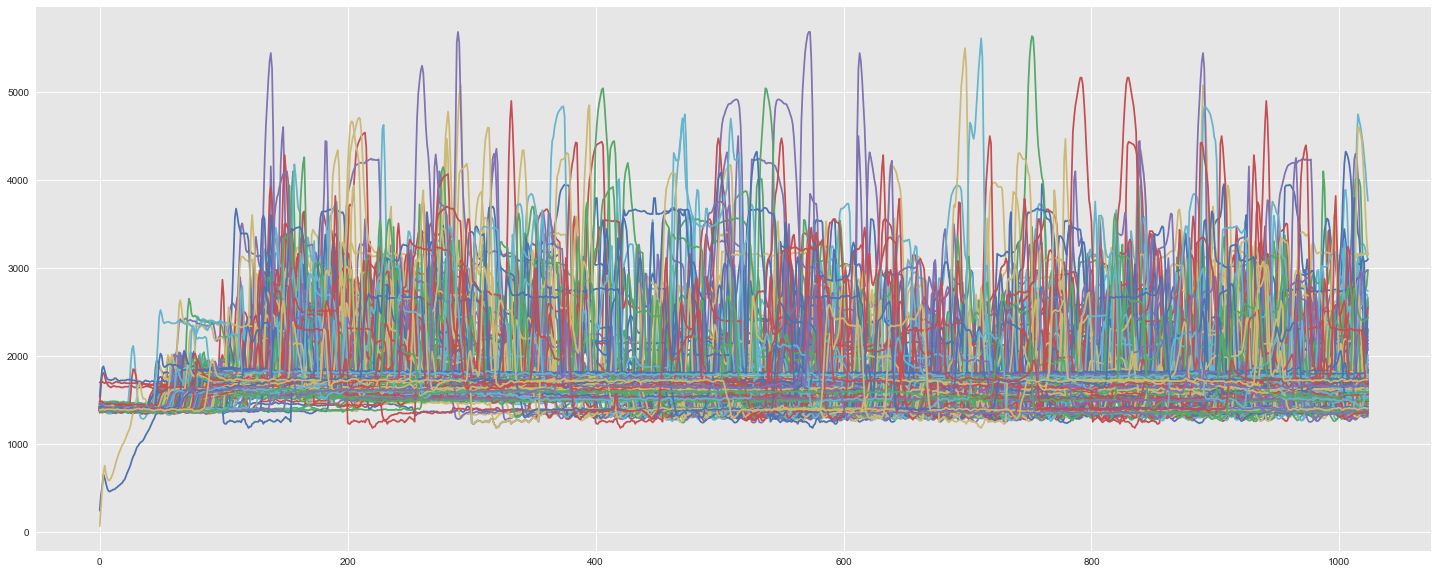

In [3]:
fig = plt.figure(figsize=(25, 10))
for x in X_1024:
    plt.plot(x)

## Décomposition en ondelettes

On effectue la décomposition en ondelettes pour chaque signal et on récupère 2 tableaux de coefficients, l'un avec tous les coefficients de chaque signal, l'autre avec les coefficients seuillés. On pourra réaliser la décomposition en ondelettes seuillés avec les modes `hard`, `soft`, `greater` ou `less`.

In [4]:
wf = 'haar'
wavelist=['haar','db2','db3','db4','coif1','coif2','coif3','sym2','sym3']

Coeff = []
TCoeff = []
for x in X_1024:
    #Apply wavelet decomposition
    coeffs = pywt.wavedec(x,wf,level=8) 
    coeffs_flatten = np.hstack(coeffs)
    Coeff.append(coeffs_flatten)
    # Compute universal Threshold http://jseabold.net/blog/2012/02/23/wavelet-regression-in-python/
    sigma = mad(coeffs[-1])
    uthresh = sigma*np.sqrt(2*np.log(1024))
    # Apply Threshold on 4 first levels
    coeffs_thresh = [pywt.threshold(c, uthresh, mode="hard") if j<=3 else c for j,c in enumerate(coeffs[::-1])]
    coeffs_thresh_flatten = np.hstack(coeffs_thresh[::-1])
    TCoeff.append(coeffs_thresh_flatten)
    
Coeff = np.array(Coeff)
TCoeff = np.array(TCoeff)
print(Coeff.shape, TCoeff.shape)
print(np.sum(Coeff!=0), np.sum(TCoeff!=0))

(425, 1024) (425, 1024)
304114 137127


**Q** : QUEL MODE DE SEUILLAGE ?

### Choix des coefficients

In [5]:
#Coefficient de niveau 7 :
Coeff7=Coeff[:,128:]
#Coefficient de niveau 1 à 6 : 
CoeffA6=Coeff[:,:128]
#Coefficient de niveau 1 à 4 : 
CoeffA4=Coeff[:,:16]

In [6]:
Coeff_liste=["Coeff","Coeff7","CoeffA6","CoeffA4","TCoeff"]
dict_coeff ={"Coeff" : Coeff,"Coeff7" : Coeff7, "CoeffA6" : CoeffA6, "CoeffA4" : CoeffA4, "TCoeff" : TCoeff}
def f(x) :
    return dict_coeff[x]
interact(f,x=Coeff_liste)

interactive(children=(Dropdown(description='x', options=('Coeff', 'Coeff7', 'CoeffA6', 'CoeffA4', 'TCoeff'), value='Coeff'), Output()), _dom_classes=('widget-interact',))

<function __main__.f>

## Analyse en composantes principales sur les coefficients d'ondelettes

### Fonctions d'affichage

In [7]:
def plot_var_ACP(X_acp, acp) :
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(1,2,1)
    ax.bar(range(10), acp.explained_variance_ratio_[:10]*100, align='center', color='grey', ecolor='black')
    ax.set_xticks(range(10))
    ax.set_ylabel("Variance")
    ax.set_title("Pourcentage de variance expliquée \n des premières composantes", fontsize=20)

    ax = fig.add_subplot(1,2,2)
    box = ax.boxplot(X_acp[:, 0:10])
    ax.set_title("Distribution des premières composantes", fontsize=20)
    plt.show()
    
def plot_proj_ACP(X_acp, axe_1=0, axe_2=1, etiq=True) :
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(1,1,1)
    dict_color = {True : "blue", False : "red"}

    for x, y, s in zip(X_acp[:,axe_1], X_acp[:,axe_2], ind) :
        ax.plot(x,y,marker=".", color=dict_color[s < 300]) #300 : longueur liste apprentissage
        if etiq :
            ax.text(x, y, str(s))
       
    ax.set_title("Projection des invididus sur les \n  deux premières composantes", fontsize=20)

    legend_elements = [Line2D([0], [0], marker='.', color='blue', label='Série du jeu d\'apprentissage', markersize=10, linewidth=0),
                       Line2D([0], [0], marker='.', color='red', label='Série du jeu de test', markersize=10, linewidth=0)]

    ax.legend(handles=legend_elements)

    plt.show()
    

### Calcul des différents coefficients d'ACP (A GARDER POUR L'INSTANT)

In [8]:
# Tous les coefficients d'ondelettes
acp_ond = sd.PCA()
X_acp_ond = acp_ond.fit_transform(sp.scale(Coeff))
# Ondelettes de niveau 7 
acp_ond7 = sd.PCA()
X_acp_ond7 = acp_ond7.fit_transform(sp.scale(Coeff7))
# Ondelettes de niveau 1 à 6
acp_ondA6 = sd.PCA()
X_acp_ondA6 = acp_ondA6.fit_transform(sp.scale(CoeffA6))
# Ondelettes de niveau 1 à 4
acp_ondA4 = sd.PCA()
X_acp_ondA4 = acp_ondA4.fit_transform(sp.scale(CoeffA4))
# Coefficients seuillés
acp_ondT = sd.PCA()
X_acp_ondT = acp_ondT.fit_transform(sp.scale(TCoeff))

### Visualisation des résultats

Ondelettes, tous les coefficients :


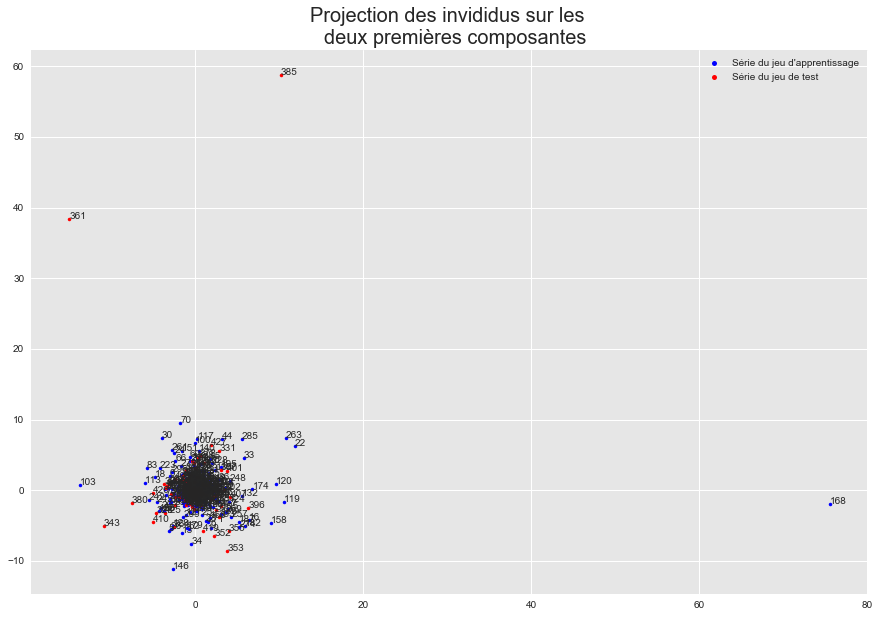

Ondelette, niveau 7 :


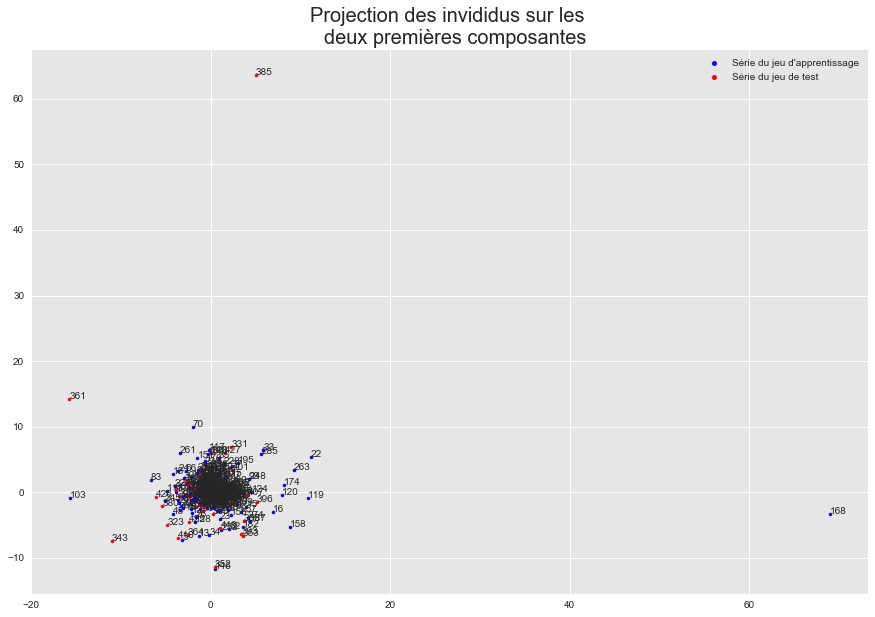

Ondelette, niveaux 1 a 6 :


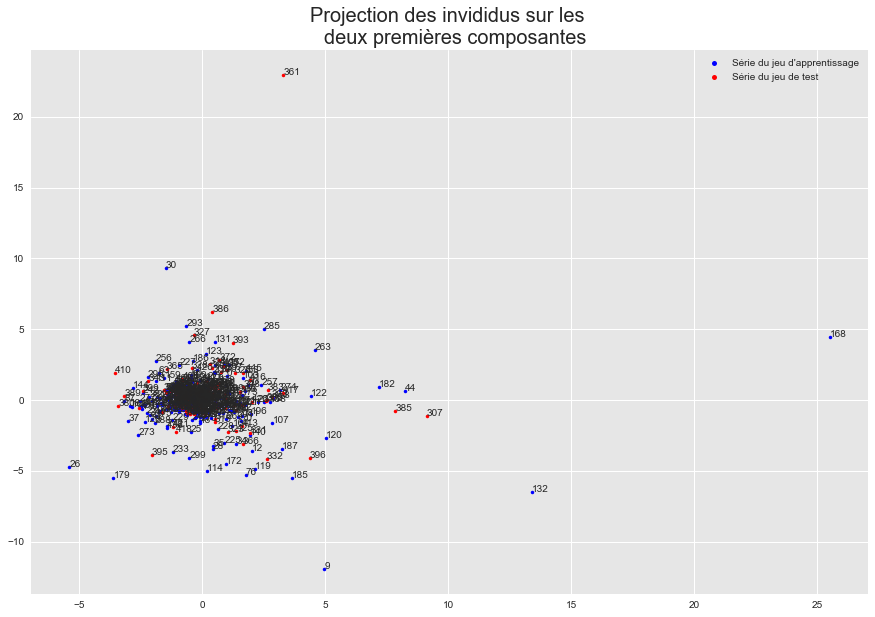

Ondelette, niveaux 1 a 4 :


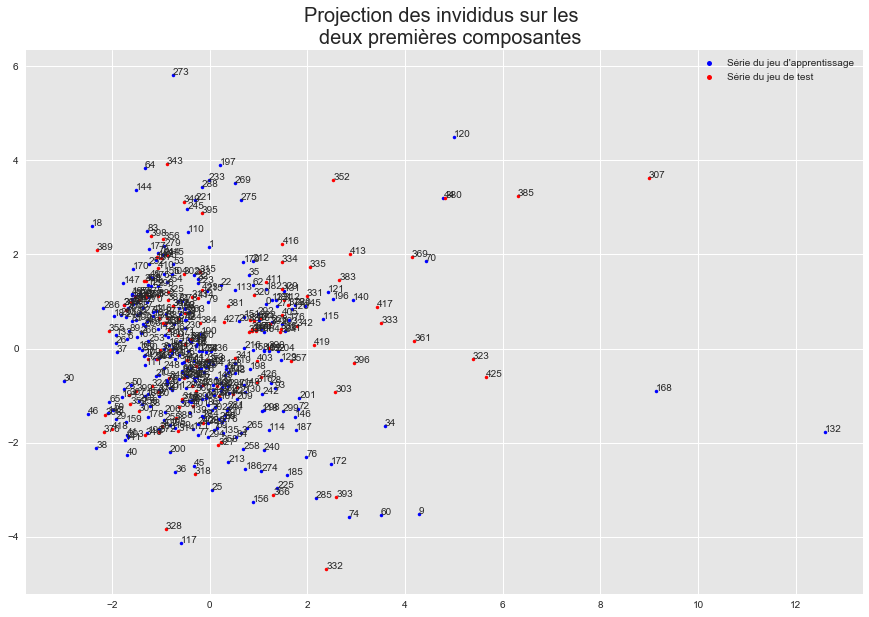

Ondelette, coefficients seuilles :


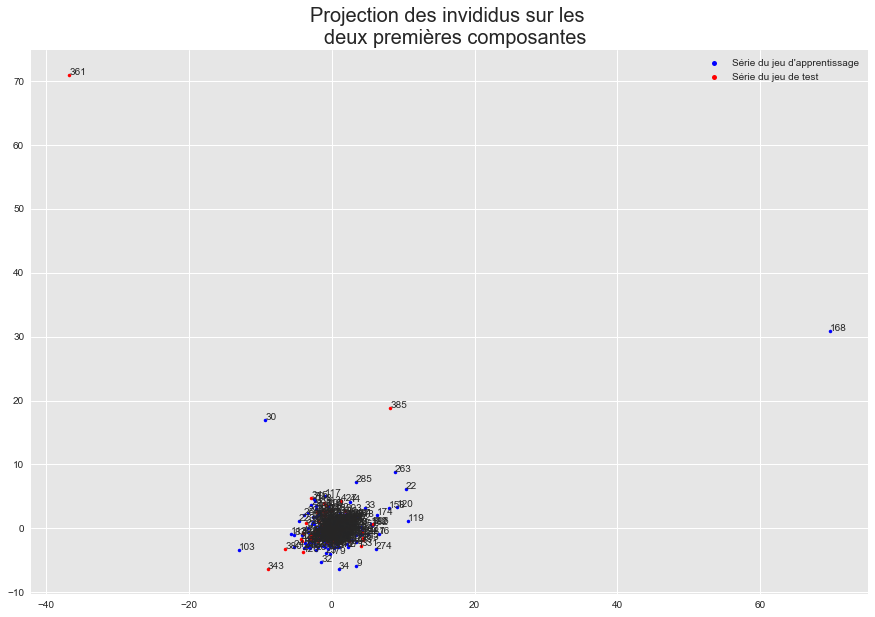

In [9]:
print("Ondelettes, tous les coefficients :")
plot_proj_ACP(X_acp_ond)
print("Ondelette, niveau 7 :")
plot_proj_ACP(X_acp_ond7)
print("Ondelette, niveaux 1 a 6 :")
plot_proj_ACP(X_acp_ondA6)
print("Ondelette, niveaux 1 a 4 :")
plot_proj_ACP(X_acp_ondA4)
print("Ondelette, coefficients seuilles :")
plot_proj_ACP(X_acp_ondT)
plt.show()

In [10]:
@interact(Choix_coeff=Coeff_liste)
def ACP(Choix_coeff):
    Coeff=dict_coeff[Choix_coeff]
    acp_ond = sd.PCA()
    X_acp_ond = acp_ond.fit_transform(sp.scale(Coeff))
    plot_var_ACP(X_acp_ond, acp_ond)
    plot_proj_ACP(X_acp_ond, axe_1=0, axe_2=1)

interactive(children=(Dropdown(description='Choix_coeff', options=('Coeff', 'Coeff7', 'CoeffA6', 'CoeffA4', 'TCoeff'), value='Coeff'), Output()), _dom_classes=('widget-interact',))

## Classification ascendante hierarchique

### Fonction d'affichage

In [11]:
def plot_dendrogram(Z,p):
    fig = plt.figure(figsize=(25, 10))
    sch.dendrogram( Z, p, leaf_rotation=45.,leaf_font_size=15, truncate_mode="level", labels=ind)  # font size for the x axis labels
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('sample index')
    plt.ylabel('distance')
    plt.show()

### Calculs (A GARDER POUR L'INSTANT)

In [12]:
# Tous les coefficients d'ondelettes
Z_ond = sch.linkage(Coeff, 'single')
C = np.array([c[0] for c in sch.cut_tree(Z_ond,5)])
CT_ond = pd.DataFrame(list(C), columns=["HCA_cluster"])
# Ondelettes de niveau 7 
Z_ond7 = sch.linkage(Coeff7, 'single')
C = np.array([c[0] for c in sch.cut_tree(Z_ond7,5)])
CT_ond7 = pd.DataFrame(list(C), columns=["HCA_cluster"])
# Ondelettes de niveau 1 à 6
Z_ondA6 = sch.linkage(CoeffA6, 'single')
C = np.array([c[0] for c in sch.cut_tree(Z_ondA6,5)])
CT_ondA6 = pd.DataFrame(list(C), columns=["HCA_cluster"])
# Ondelettes de niveau 1 à 4
Z_ondA4 = sch.linkage(CoeffA4, 'single')
C = np.array([c[0] for c in sch.cut_tree(Z_ondA4,5)])
CT_ondA4 = pd.DataFrame(list(C), columns=["HCA_cluster"])
# Coefficients seuillés
Z_ondT = sch.linkage(TCoeff, 'single')
C = np.array([c[0] for c in sch.cut_tree(Z_ondT,5)])
CT_ondT = pd.DataFrame(list(C), columns=["HCA_cluster"])

### Visualisation des résultats

Ondelettes, tous les coefficients :


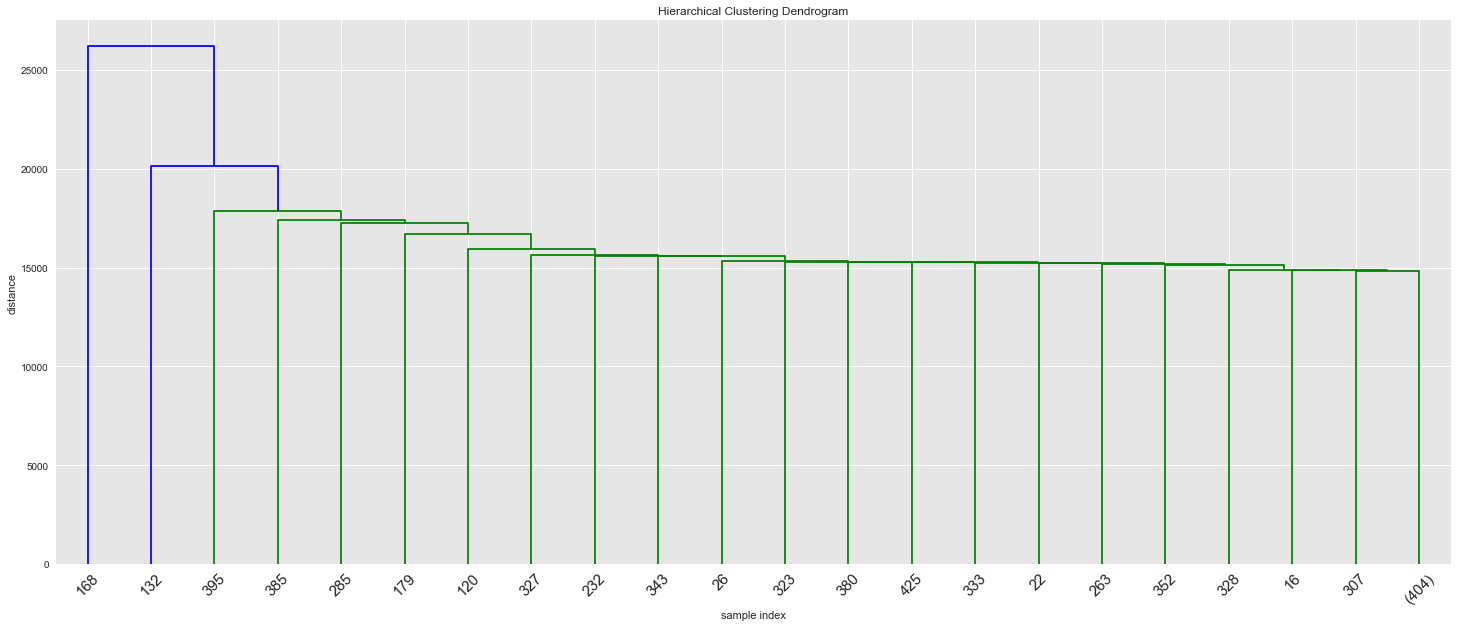

Ondelette, niveau 7 :


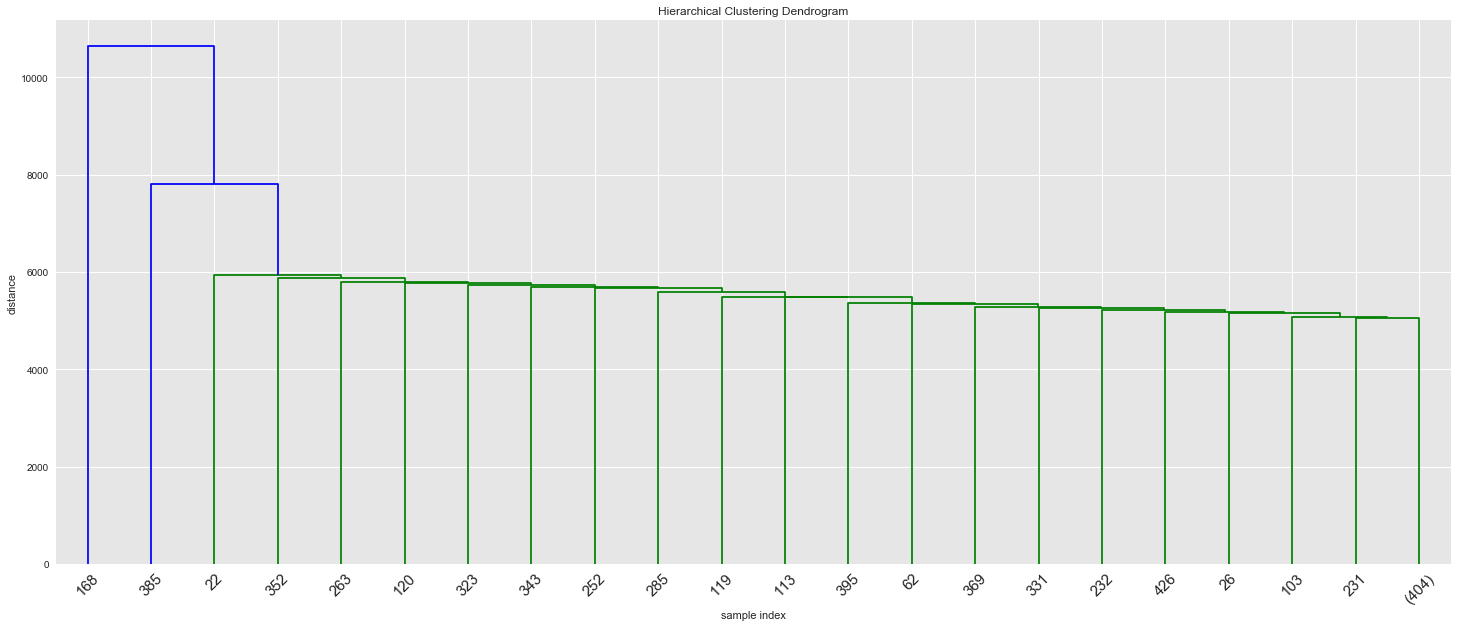

Ondelette, niveaux 1 a 6 :


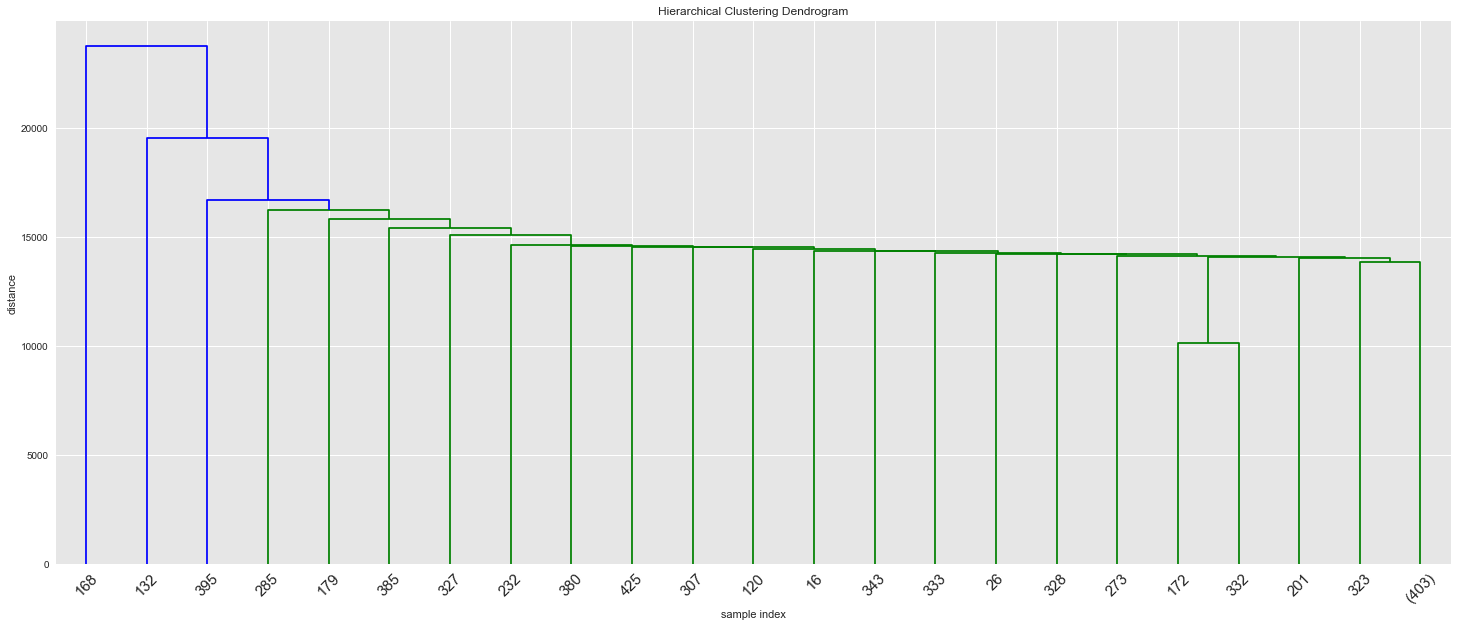

Ondelette, niveaux 1 a 4 :


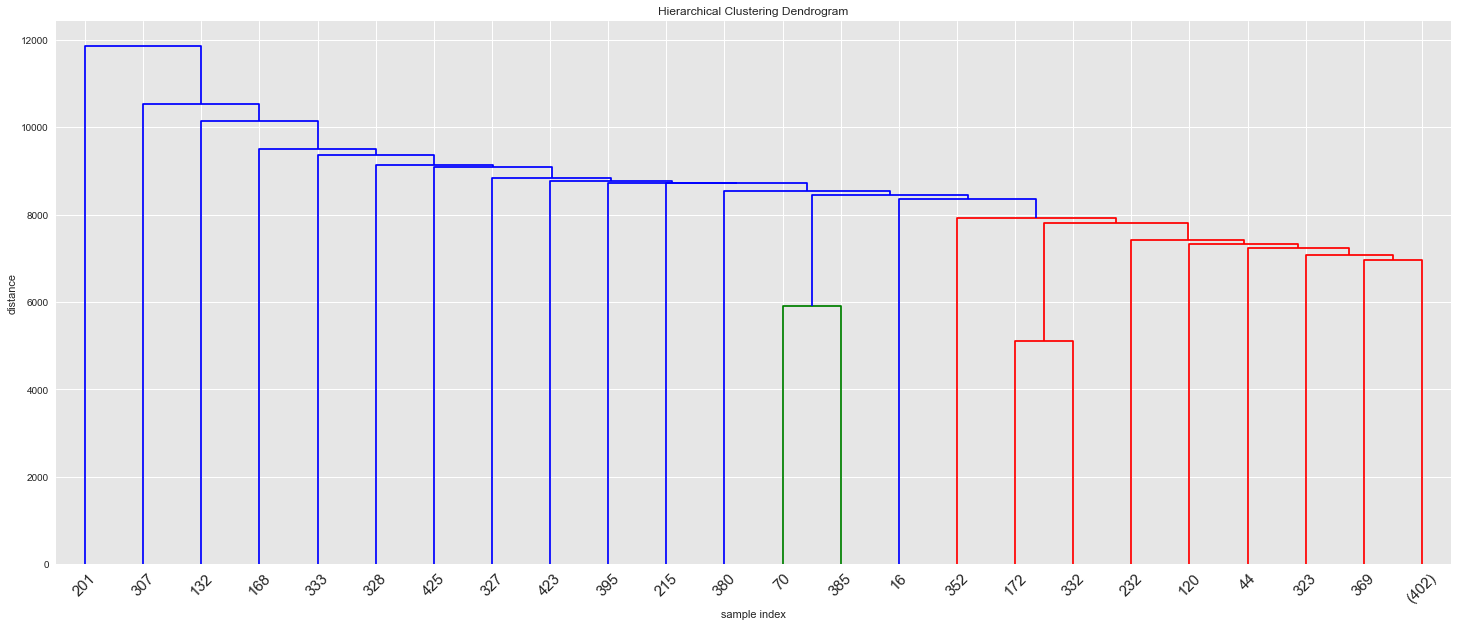

Ondelette, coefficients seuilles :


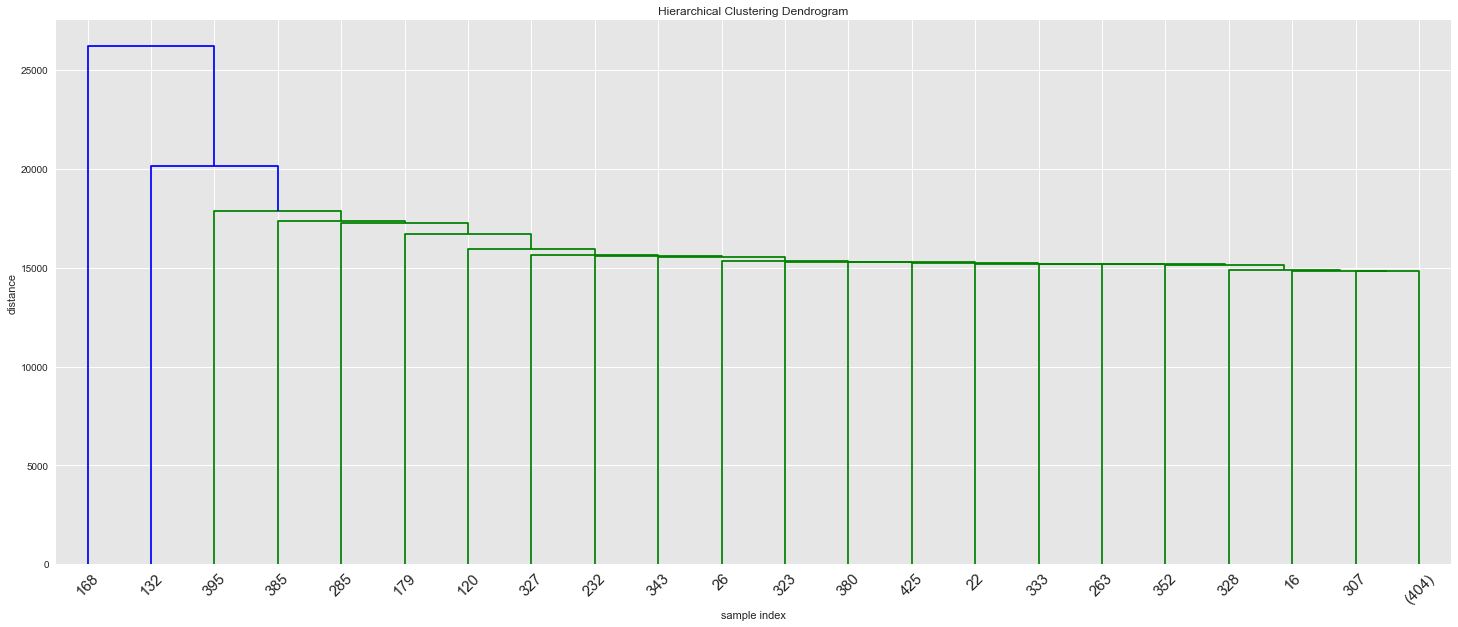

In [13]:
p=20
print("Ondelettes, tous les coefficients :")
plot_dendrogram(Z_ond,p)
print("Ondelette, niveau 7 :")
plot_dendrogram(Z_ond7,p)
print("Ondelette, niveaux 1 a 6 :")
plot_dendrogram(Z_ondA6,p)
print("Ondelette, niveaux 1 a 4 :")
plot_dendrogram(Z_ondA4,p)
print("Ondelette, coefficients seuilles :")
plot_dendrogram(Z_ondT,p)
plt.show()

In [14]:
@interact(Choix_coeff=Coeff_liste,p=widgets.IntSlider(min=1,max=50,step=1,value=20,continuous_update=False))
def CAH(Choix_coeff,p):
    Coeff=dict_coeff[Choix_coeff]
    Z = sch.linkage(Coeff, 'single')
    C = np.array([c[0] for c in sch.cut_tree(Z,5)])
    CT = pd.DataFrame(list(C), columns=["HCA_cluster"])
    plot_dendrogram(Z,p)
    

interactive(children=(Dropdown(description='Choix_coeff', options=('Coeff', 'Coeff7', 'CoeffA6', 'CoeffA4', 'TCoeff'), value='Coeff'), IntSlider(value=20, continuous_update=False, description='p', max=50, min=1), Output()), _dom_classes=('widget-interact',))

## Fonctions de visualistion des résultats pour IF, OC-SVM, LOF

In [15]:
def make_figure(fig, ax, CT, legend=False):
    y_lim = (-1.13,1.13)
    x_lim = [-5,n+5]
    CT_Normal = CT[CT.pred==1]
    CT_Anomaly = CT[CT.pred==-1]
    
    ax.scatter(CT_Normal.index, - CT_Normal.pred, color="green", label="Normal")
    ax.scatter(CT_Anomaly.index, - CT_Anomaly.pred, color="red", label="Anomaly detected")
    
    #for x,y,s in zip(CT_Anomaly.index, - CT_Anomaly.pred, map(str,CT_Anomaly.index)):
    #    ax.text(x,y,s, horizontalalignment="center", verticalalignment="center", color="red")

    ax.plot(x_lim, [0,0], color="black")
    ax.set_xlim(*x_lim)
    ax.set_ylim(y_lim)
    
    if legend:
        plt.legend(bbox_to_anchor=(1,1), fontsize=20)

In [16]:
def print_anomalies(ind_anomalies,ind_data = ind):
    return [ind_data[i] for i in ind_anomalies]

**A ADAPTER**

In [17]:
#Methode : IF, OC-SVM, LOF
#contamination : IF, LOF
#nu : OC-SVM
#n_neighbors : LOF
def level(X_acp_ond,contamination,methode): 
    xx, yy = np.meshgrid(np.linspace(X_acp_ond[:,0].min()-5, X_acp_ond[:,0].max()+5, 500), 
                         np.linspace(X_acp_ond[:,1].min()-1, X_acp_ond[:,1].max()+1, 500))
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.set_title(str(methode) + ", contamination = %f" + str(contamination))
    ax.contourf(xx, yy, Z, levels=[Z.min(), clf.threshold_, Z.max()], cmap = plt.cm.PuBu)

    s = 40
    b1 = plt.scatter(X_acp_ond[:,0], X_acp_ond[:,1], c='white', s=s, edgecolors='k')
    labels=[]
    for x,y,ss,  in zip(X_acp_ond[:,0], X_acp_ond[:,1], map(str,ind)):
        ax.scatter(x,y, c=COLOR_DIC[a],  s=s, edgecolors='k')
    plt.legend()

## Isolation Forest

In [18]:
def IF(Coeff,contamination):
    clf = se.IsolationForest(n_estimators=100, contamination=contamination, bootstrap=True, n_jobs=-1)
    clf.fit(Coeff)
    y_pred = clf.predict(Coeff)
    return pd.DataFrame(list(y_pred), columns=["pred"])

Q : QUEL CHOIX DE `contamination` (proportion d'outliers) ?

In [19]:
contamination=20/n
#Sur tous les coefficients d'ondelettes
CT_IF_ond = IF(Coeff,contamination)
#Sur les coefficients d'ondelettes de niveau 7
CT_IF_ond7 = IF(Coeff7,contamination)
#Sur les coefficients d'ondelettes de niveaux 0 à 6
CT_IF_ondA6 = IF(CoeffA6,contamination)
#Sur les coefficients d'ondelettes de niveaux 0 à 4
CT_IF_ondA4 = IF(CoeffA4,contamination)
#Sur les coefficients d'ondelettes seuillés
CT_IF_ondT = IF(TCoeff,contamination) 

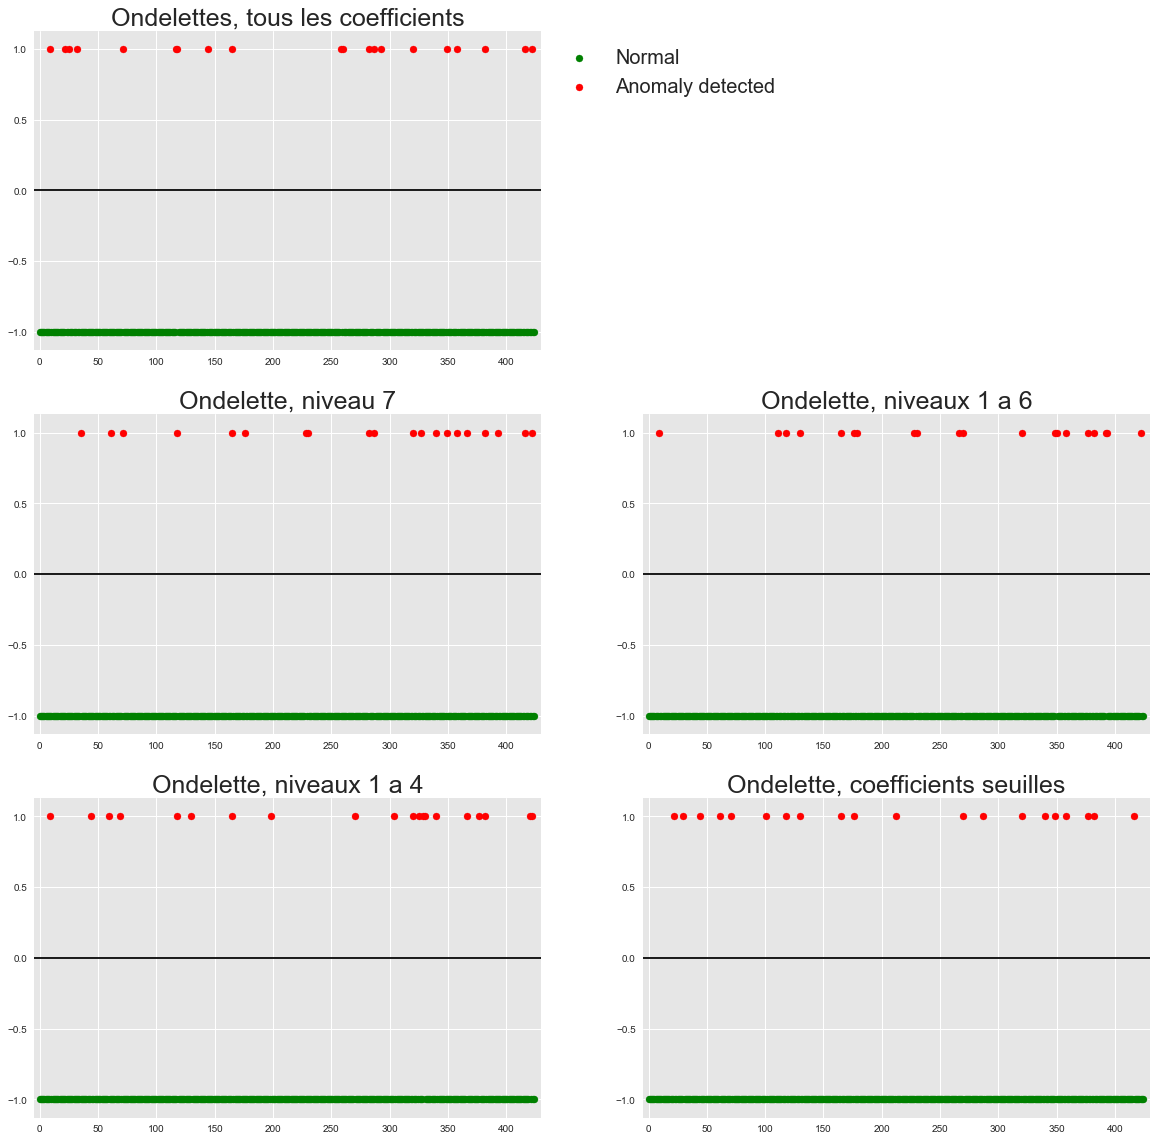

In [20]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(3,2,1)
make_figure(fig,ax,CT_IF_ond,legend=True)
ax.set_title("Ondelettes, tous les coefficients", fontsize=25)
ax = fig.add_subplot(3,2,3)
make_figure(fig,ax,CT_IF_ond7)
ax.set_title("Ondelette, niveau 7", fontsize=25)
ax = fig.add_subplot(3,2,4)
make_figure(fig,ax,CT_IF_ondA6)
ax.set_title("Ondelette, niveaux 1 a 6", fontsize=25)
ax = fig.add_subplot(3,2,5)
make_figure(fig,ax,CT_IF_ondA4)
ax.set_title("Ondelette, niveaux 1 a 4", fontsize=25)
ax = fig.add_subplot(3,2,6)
make_figure(fig,ax,CT_IF_ondT)
ax.set_title("Ondelette, coefficients seuilles", fontsize=25)
plt.show()

In [21]:
print("Anomalies avec tous les coefficients : ", print_anomalies(CT_IF_ond[CT_IF_ond.pred==-1].index.values))
print("Anomalies avec coefficients de niveau 7: ", print_anomalies(CT_IF_ond7[CT_IF_ond7.pred==-1].index.values))
print("Anomalies avec coefficients de niveaux 1 à 6: ", print_anomalies(CT_IF_ondA6[CT_IF_ondA6.pred==-1].index.values))
print("Anomalies avec coefficients de niveaux 1 à 4: ", print_anomalies(CT_IF_ondA4[CT_IF_ondA4.pred==-1].index.values))
print("Anomalies avec coefficients seuillés: ", print_anomalies(CT_IF_ondT[CT_IF_ondT.pred==-1].index.values))

Anomalies avec tous les coefficients :  [9, 22, 25, 32, 72, 119, 120, 146, 168, 261, 263, 285, 290, 296, 323, 352, 361, 385, 419, 425]
Anomalies avec coefficients de niveau 7:  [35, 62, 72, 120, 168, 179, 231, 233, 285, 290, 323, 330, 343, 352, 361, 369, 385, 396, 419, 425]
Anomalies avec coefficients de niveaux 1 à 6:  [9, 113, 120, 132, 168, 179, 182, 231, 233, 269, 273, 323, 352, 353, 361, 380, 385, 395, 396, 425]
Anomalies avec coefficients de niveaux 1 à 4:  [9, 44, 60, 70, 120, 132, 168, 201, 273, 307, 323, 328, 332, 333, 343, 369, 380, 385, 423, 425]
Anomalies avec coefficients seuillés:  [22, 30, 44, 62, 72, 103, 120, 132, 168, 179, 215, 273, 290, 323, 343, 352, 361, 380, 385, 419]


## One Class SVM

In [22]:
def OCSVM(Coeff,nu):
    OCS = ssvm.OneClassSVM(kernel="rbf",nu=nu)
    OCS.fit(Coeff)
    pred = OCS.predict(Coeff)
    return pd.DataFrame(list(pred), columns=["pred"])

**AFFINER LE CHOIX DE NU + verifier comment ça marche**

In [23]:
nu=20/n
#Sur tous les coefficients d'ondelettes
CT_OCSVM_ond = OCSVM(Coeff,1-nu)
#Sur les coefficients d'ondelettes de niveau 7
CT_OCSVM_ond7 = OCSVM(Coeff7,1-nu)
#Sur les coefficients d'ondelettes de niveaux 0 à 6
CT_OCSVM_ondA6 = OCSVM(CoeffA6,1-nu)
#Sur les coefficients d'ondelettes de niveaux 0 à 4
CT_OCSVM_ondA4 = OCSVM(CoeffA4,1-nu)
#Sur les coefficients d'ondelettes seuillés
CT_OCSVM_ondT = OCSVM(TCoeff,1-nu)

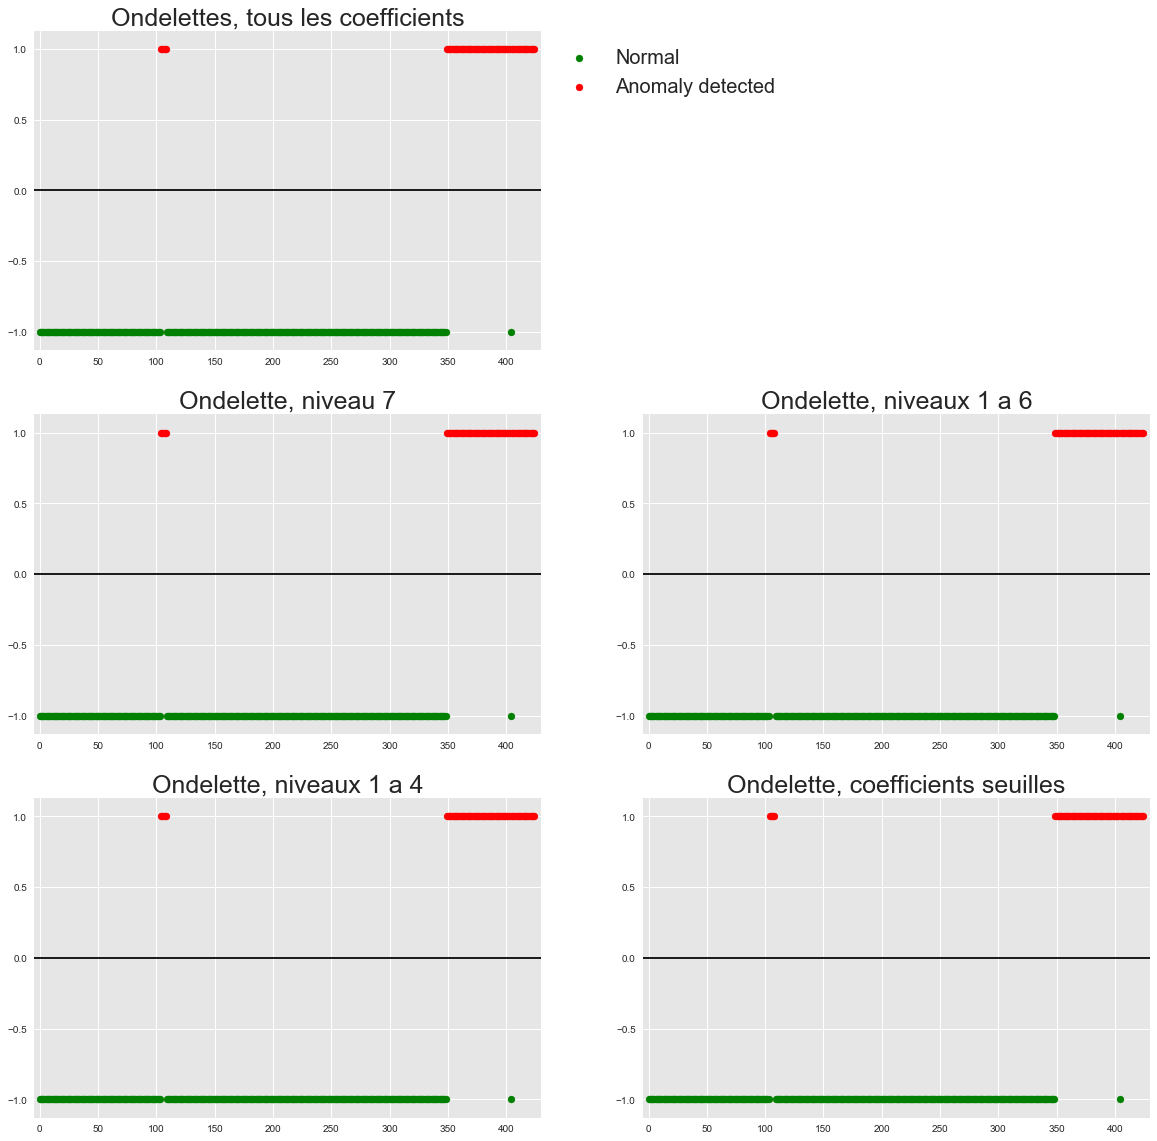

In [24]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(3,2,1)
make_figure(fig,ax,CT_OCSVM_ond,legend=True)
ax.set_title("Ondelettes, tous les coefficients", fontsize=25)
ax = fig.add_subplot(3,2,3)
make_figure(fig,ax,CT_OCSVM_ond7)
ax.set_title("Ondelette, niveau 7", fontsize=25)
ax = fig.add_subplot(3,2,4)
make_figure(fig,ax,CT_OCSVM_ondA6)
ax.set_title("Ondelette, niveaux 1 a 6", fontsize=25)
ax = fig.add_subplot(3,2,5)
make_figure(fig,ax,CT_OCSVM_ondA4)
ax.set_title("Ondelette, niveaux 1 a 4", fontsize=25)
ax = fig.add_subplot(3,2,6)
make_figure(fig,ax,CT_OCSVM_ondT)
ax.set_title("Ondelette, coefficients seuilles", fontsize=25)
plt.show()

In [25]:
print("Anomalies avec tous les coefficients : ", print_anomalies(CT_OCSVM_ond[CT_OCSVM_ond.pred==-1].index.values))
print("Anomalies avec coefficients de niveau 7: ", print_anomalies(CT_OCSVM_ond7[CT_OCSVM_ond7.pred==-1].index.values))
print("Anomalies avec coefficients de niveaux 1 à 6: ", print_anomalies(CT_OCSVM_ondA6[CT_OCSVM_ondA6.pred==-1].index.values))
print("Anomalies avec coefficients de niveaux 1 à 4: ", print_anomalies(CT_OCSVM_ondA4[CT_OCSVM_ondA4.pred==-1].index.values))
print("Anomalies avec coefficients seuillés: ", print_anomalies(CT_OCSVM_ondT[CT_OCSVM_ondT.pred==-1].index.values))

Anomalies avec tous les coefficients :  [106, 107, 108, 109, 110, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427]
Anomalies avec coefficients de niveau 7:  [106, 107, 108, 109, 110, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427]
Anomalies avec coefficients de niveaux 1 à 6:  [106, 107, 108, 109, 110, 352, 353, 354, 355, 356, 357, 358, 359, 360

## Local Outlier Factor

In [26]:
def LOF(Coeff,contamination,metric,n_neighbors):
    clf = sn.LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination, metric=metric)
    y_pred = clf.fit_predict(Coeff)
    return pd.DataFrame(list(y_pred), columns=["pred"])

In [27]:
contamination=20/n
metric = "euclidean"
n_neighbors = 15
#Sur tous les coefficients d'ondelettes
CT_LOF_ond = LOF(Coeff,contamination,metric,n_neighbors)
#Sur les coefficients d'ondelettes de niveau 7
CT_LOF_ond7 = LOF(Coeff7,contamination,metric,n_neighbors)
#Sur les coefficients d'ondelettes de niveaux 0 à 6
CT_LOF_ondA6 = LOF(CoeffA6,contamination,metric,n_neighbors)
#Sur les coefficients d'ondelettes de niveaux 0 à 4
CT_LOF_ondA4 = LOF(CoeffA4,contamination,metric,n_neighbors)
#Sur les coefficients d'ondelettes seuillés
CT_LOF_ondT = LOF(TCoeff,contamination,metric,n_neighbors)

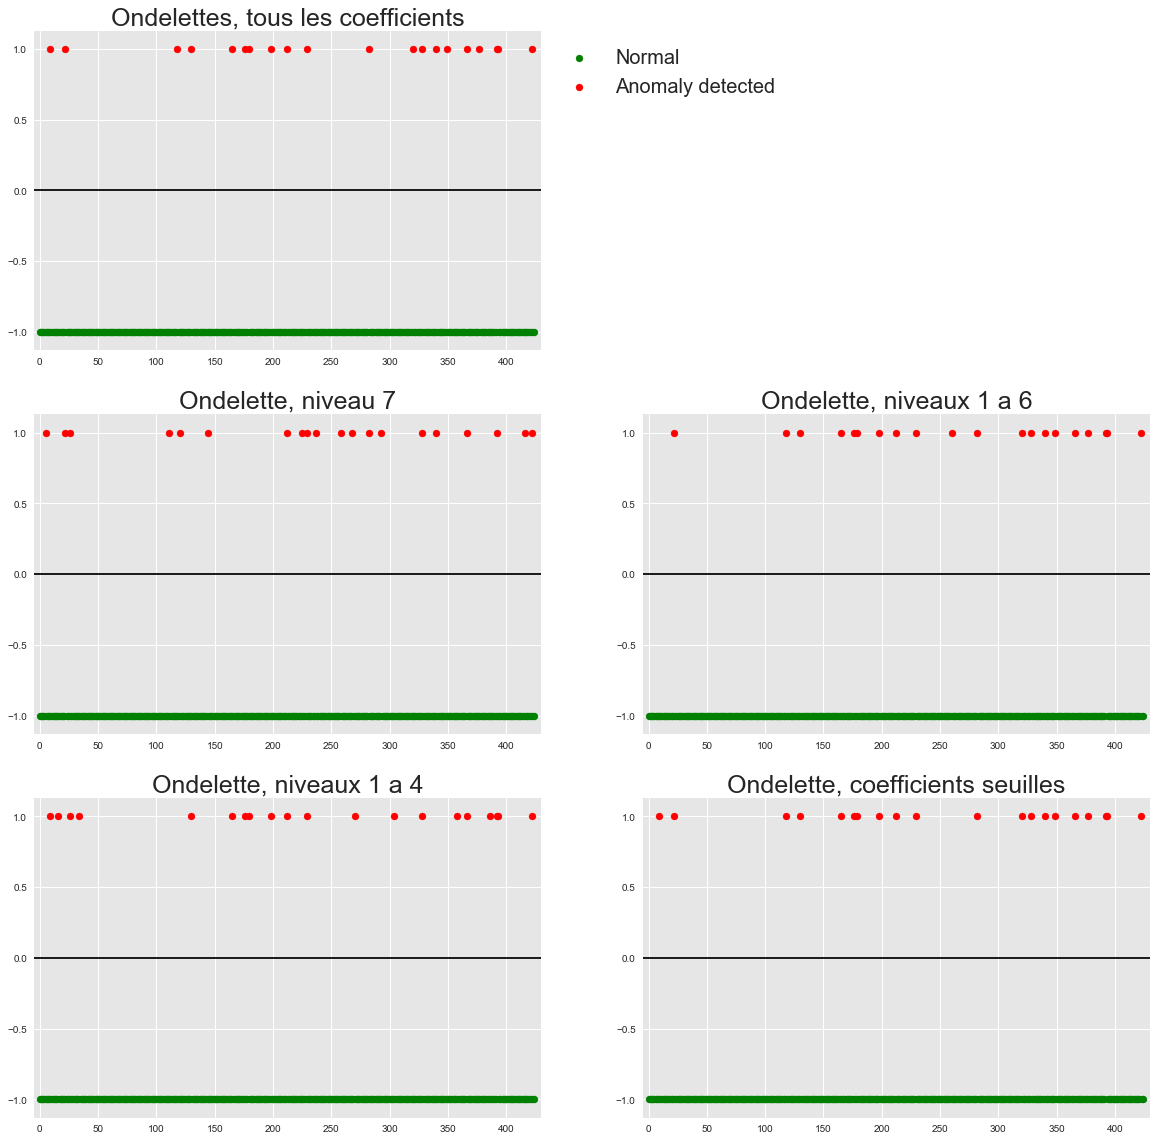

In [28]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(3,2,1)
make_figure(fig,ax,CT_LOF_ond,legend=True)
ax.set_title("Ondelettes, tous les coefficients", fontsize=25)
ax = fig.add_subplot(3,2,3)
make_figure(fig,ax,CT_LOF_ond7)
ax.set_title("Ondelette, niveau 7", fontsize=25)
ax = fig.add_subplot(3,2,4)
make_figure(fig,ax,CT_LOF_ondA6)
ax.set_title("Ondelette, niveaux 1 a 6", fontsize=25)
ax = fig.add_subplot(3,2,5)
make_figure(fig,ax,CT_LOF_ondA4)
ax.set_title("Ondelette, niveaux 1 a 4", fontsize=25)
ax = fig.add_subplot(3,2,6)
make_figure(fig,ax,CT_LOF_ondT)
ax.set_title("Ondelette, coefficients seuilles", fontsize=25)
plt.show()

In [29]:
print("Anomalies avec tous les coefficients : ", print_anomalies(CT_LOF_ond[CT_LOF_ond.pred==-1].index.values))
print("Anomalies avec coefficients de niveau 7: ", print_anomalies(CT_LOF_ond7[CT_LOF_ond7.pred==-1].index.values))
print("Anomalies avec coefficients de niveaux 1 à 6: ", print_anomalies(CT_LOF_ondA6[CT_LOF_ondA6.pred==-1].index.values))
print("Anomalies avec coefficients de niveaux 1 à 4: ", print_anomalies(CT_LOF_ondA4[CT_LOF_ondA4.pred==-1].index.values))
print("Anomalies avec coefficients seuillés: ", print_anomalies(CT_LOF_ondT[CT_LOF_ondT.pred==-1].index.values))

Anomalies avec tous les coefficients :  [9, 22, 120, 132, 168, 179, 182, 201, 215, 232, 285, 323, 331, 343, 352, 369, 380, 395, 396, 425]
Anomalies avec coefficients de niveau 7:  [5, 22, 26, 113, 122, 146, 215, 228, 232, 240, 261, 271, 285, 296, 331, 343, 369, 395, 419, 425]
Anomalies avec coefficients de niveaux 1 à 6:  [22, 120, 132, 168, 179, 182, 201, 215, 232, 263, 285, 323, 331, 343, 352, 369, 380, 395, 396, 425]
Anomalies avec coefficients de niveaux 1 à 4:  [9, 16, 26, 34, 132, 168, 179, 182, 201, 215, 232, 273, 307, 331, 361, 369, 389, 395, 396, 425]
Anomalies avec coefficients seuillés:  [9, 22, 120, 132, 168, 179, 182, 201, 215, 232, 285, 323, 331, 343, 352, 369, 380, 395, 396, 425]
